# Downloading Nemo Data

The [SalishSeaCast](https://salishsea.eos.ubc.ca/nemo/#) project provides access to their model forecasts and historic model results through their [ERDDAP](https://salishsea.eos.ubc.ca/erddap/index.html) server. This data does cover the time & geospatial bounds we are using for the NSOG range test. 

The granularity of this data is fine. Grid positions are _very_ close to one another & most of the historic variables have been retained at hourly intervals. 

One trick with this data is that the environmental data itself doesn't include lat/lon coordinates. Instead, these files contain `gridX`/`gridY` coordinates. To find the corresponding lat/lon coordinates you have to use the [geolocation and bathymetry data](https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02.html). This dataset contains the lat, lon, and maximum depth at each gridX & gridY coordinate. The key here is that you must match the entire gridX/gridY coordinate to get either gridX. In other words (or an equation) `lat = f(gridX, gridY)`. 

One solution to this, is to merge the environmental variable & geolocation data & save that to a netCDF file for `range_driver` to ingest. However, if you re-index the XArray -- 

In [2]:
import json
import range_driver as at
import pandas as pd
from ipyleaflet import Map, Marker, Rectangle
import requests
import xarray as xr
from pathlib import Path

//anaconda3/envs/range-driver/lib/python3.8/site-packages/kadlu/geospatial/data_sources/data_util.py:44: UserWarning: storage location not configured. storage location will be set to /Users/jilliana/kadlu_data/
  warnings.warn(f'{msg} storage location will be set to {storage_location}')
//anaconda3/envs/range-driver/lib/python3.8/site-packages/kadlu/geospatial/data_sources/data_util.py:44: UserWarning: storage location not configured. storage location will be set to /Users/jilliana/kadlu_data/
  warnings.warn(f'{msg} storage location will be set to {storage_location}')


# Load Config File

In [6]:
# Read Config File 
baseconfig = at.yload(at.load_file("configs/base_config.yaml"))
viewconfig = at.yload(at.load_file("configs/view_config.yaml"))
at.deep_update(baseconfig, viewconfig)
rawconfig = at.yload(at.load_file("configs/nsog_jan2018_config.yaml"))
config = at.merge_dicts(baseconfig, rawconfig)
at.prepare_config(config)


# Update our bounds for custom download
# (Optional -- done b/c this dataset is so fine grained)
config['bounds']['north'] = config['bounds']['lat_center'] + 0.015
config['bounds']['south'] = config['bounds']['lat_center'] - 0.015
config['bounds']['east'] = config['bounds']['lon_center'] + 0.05
config['bounds']['west'] = config['bounds']['lon_center'] - 0.03
config['bounds']['start'] = '2018-01-01'
config['bounds']['end'] = '2018-02-01'

# Load the Bathymetry Data
The next thing we need to do is read in the region information file for the full NEMO dataset. This will provide the mapping from (gridX, gridY) position to (lon, lat) coordinates. As well, the bathymetry data in the file, will let us refine the range of depths we collect the environmental data for.

The function below will look for the file on disk. If it doesn't find it, it will download the bathy file from the [SalishSeaCast ERDDAP](https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02.html) server.

In [13]:
def read_nemo_region(file_path, allow_download=True):
    try:
        bathy_xr = xr.open_dataset(file_path)
    except FileNotFoundError:
        if allow_download:
            print(f"File not found at filepath. Downloading file to {file_path}")
            url = "https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02.nc?bathymetry[(0.0):1:(897.0)][(0.0):1:(397.0)],latitude[(0.0):1:(897.0)][(0.0):1:(397.0)],longitude[(0.0):1:(897.0)][(0.0):1:(397.0)]"
            r = requests.get(url)
            with open(file_path, 'wb+') as f:
                f.write(r.content)
            bathy_xr = xr.open_dataset(file_name)
        else:
            raise FileNotFoundError
    return bathy_xr

In [14]:
nemo_bathy_loc = 'data/SalishSeaCast/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc'
bathy_xr = read_nemo_region(nemo_bathy_loc, allow_download=True)

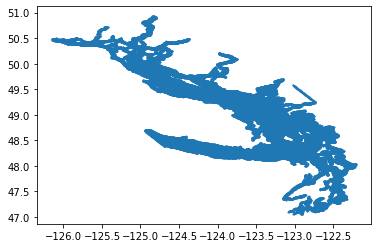

In [35]:
import matplotlib.pyplot as plt

bathy_df = bathy_xr.to_dataframe()
no_nans = bathy_df.dropna()
plt.scatter(no_nans['longitude'], no_nans['latitude'], s=1)

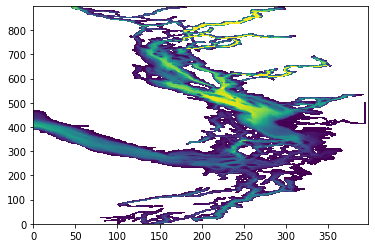

In [40]:
plt.pcolormesh(bathy_xr['bathymetry'])

# Find ERDDAP Bounds

Next, we need to figure out what bounds we will use when we retreieve environmental data from the ERDDAP server. The trick here is that the ERDDAP server doesn't use lon/lat boundaries, but instead uses gridX/gridY boundaries. We will use the bathymetry dataset we downloaded previously to determine what boundaries we will use when querying the ERDDAP servers. 

In [5]:
def find_erddap_bounds(bathy_data, bounds):
    def in_bounds(data):
        return (bounds['north'] >= data.latitude) & \
               (bounds['south'] <= data.latitude) & \
               (bounds['east'] >= data.longitude) & \
               (bounds['west'] <= data.longitude)

    filtered = bathy_data.where(in_bounds, drop=True)

    gridX = filtered['gridX'].to_series()
    gridX_min = gridX.min()
    gridX_max = gridX.max()

    gridY = filtered['gridY'].to_series()
    gridY_min = gridY.min()
    gridY_max = gridY.max()

    depth = filtered['bathymetry'].to_series()
    depth_min = 0
    depth_max = depth.max()

    return ((gridX_min, gridX_max), 
            (gridY_min, gridY_max), 
            (depth_min, depth_max))


In [6]:
# Map lon/lat bounds to gridX, gridY, and depth bounds
bounds_gridX, bounds_gridY, bounds_depth = find_erddap_bounds(bathy_xr, config['bounds'])

# Download

In [7]:
base_url = "https://salishsea.eos.ubc.ca/erddap/griddap/"


def download_nemo_variable(variable, dataset):
    base_url = "https://salishsea.eos.ubc.ca/erddap/griddap/"
    ftype = 'nc'
    
    # Time Filter
    time_stride = 1
    time_filter = f"[({config.bounds['start']}):{time_stride}:({config.bounds['end']})]"

    # depth Filter
    depth_stride = 1
    depth_filter = f"[({bounds_depth[0]}):{depth_stride}:({bounds_depth[1]})]"

    # gridY Filter
    gridY_stride = 1
    gridY_filter = f"[({bounds_gridY[0]}):{gridY_stride}:({bounds_gridY[1]})]"

    # gridX Filter
    gridX_stride = 1
    gridX_filter = f"[({bounds_gridX[0]}):{gridX_stride}:({bounds_gridX[1]})]"

    url = f"{base_url}{dataset}.{ftype}?{variable}{time_filter}{depth_filter}{gridY_filter}{gridX_filter}"

    resp = requests.get(url)
    
    if not resp.ok:
        print(f"Something went wrong. {variable} data couldn't be downloaded.")
        return resp, url
    
    else:
        print(f"Success! {variable} data been downloaded.")
        dataset = xr.open_dataset(resp.content)
        return dataset, url     


In [8]:
data_output_path = 'data/NEMO/'
variables = {
             "uVelocity": "ubcSSg3DuGridFields1hV19-05", 
             "vVelocity": "ubcSSg3DvGridFields1hV19-05",
             "wVelocity": "ubcSSg3DwGridFields1hV19-05",
             "salinity": "ubcSSg3DTracerFields1hV19-05", 
             "temperature": "ubcSSg3DTracerFields1hV19-05",
             "fraserTurbidity": "ubcSSg3DAuxiliaryFields1hV19-05", 
             "mesozooplankton": "ubcSSg3DBiologyFields1hV19-05",
             "microzooplankton": "ubcSSg3DBiologyFields1hV19-05"
            }

ftype = "nc"

datasets = {}

tab = "  "
yaml = f"\nfile_map:\n{tab}data_dir: '{{repo_path}}/{data_output_path}'\n"

for variable in variables:
    dataset_name = variables[variable]

    
    # TODO: Add a check if the data already exists on disk before downloading it. 
    # Download the data
    var_data, url = download_nemo_variable(variable, dataset_name)

    # Merge the variable data with the bathymetry data to get lat/lon
    merged = xr.merge([var_data, bathy_xr], join='inner')\
               .rename({'latitude': 'lat', 'longitude': 'lon'})
    
    # Write the data to a NetCDF File
    start = config['bounds']['start']
    end = config['bounds']['end']
    file_name = f"{variable}_{start}_{end}.{ftype}"
    out_path = Path('./data/NEMO/') / file_name
    merged.to_netcdf(out_path)    
    
    # Add dataset to datasets dict
    datasets[variable] = merged
    
    # Add to the yaml example
    yaml += f"{tab}{variable}: {file_name}\n"    

Success! fraserTurbidity data been downloaded.
Success! mesozooplankton data been downloaded.
Success! microzooplankton data been downloaded.


In [9]:
print("Add the following lines to your config.yaml file:")
print(yaml)


Add the following lines to your config.yaml file:

file_map:
  data_dir: '{repo_path}/data/NEMO/'
  fraserTurbidity: fraserTurbidity_2018-01-01_2018-02-01.nc
  mesozooplankton: mesozooplankton_2018-01-01_2018-02-01.nc
  microzooplankton: microzooplankton_2018-01-01_2018-02-01.nc

